# 在MNIST上实现GAN   

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm
%matplotlib inline

## 定义画图函数

In [2]:
# 这是一个可视化数据的函数
def plot_data(X, labels, color = 'bone',title=None,savefig=None):
    fig, ax = plt.subplots(1, 1)
    markercolors = ['black' if label==1 else 'red' for label in labels]
    plt.scatter(X[:, 0], X[:, 1], s=8, c=markercolors, cmap=color)
    
    # 设置x-axis和y-axis的范围
    plt.xlim(-3,3)
    plt.ylim(-1,9)
    
    if title: plt.title(title)
    if savefig: plt.savefig(os.path.join("gan_images",f"{title}.png"))

## 数据集

In [3]:
# MNIST
from torchvision import datasets, transforms
batch_size = 256
dataset = datasets.MNIST(root = './data/MNIST', train = True, download = True, transform = transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=batch_size, shuffle=True,drop_last=True)

In [4]:
imgs = torch.empty(1,1,28,28)
label_choose = 3
for img,label in data_loader:
    imgs = torch.cat((imgs,img[label==label_choose]))
imgs.shape

torch.Size([6123, 1, 28, 28])

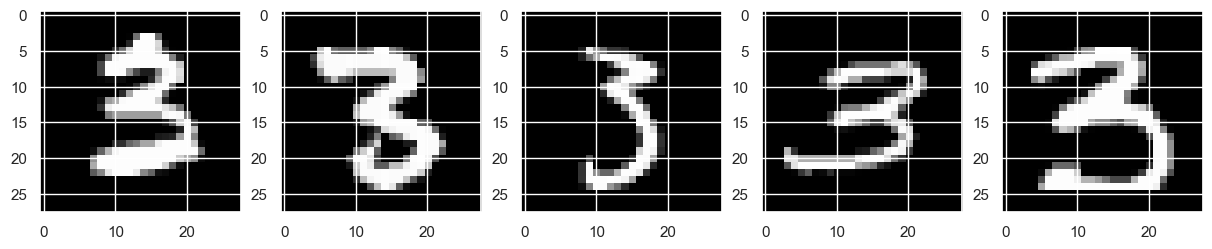

In [5]:
index = 20
fig,ax = plt.subplots(1,5,figsize=(5*3,3))
for i,index in enumerate([1,2,4,6,98]):
    ax[i].imshow(imgs[index,0],'gray')
# plt.title(label_choose)

## GAN 模型

In [6]:
input_size = 784
z_dim = 20
hidden_size = 256
# 定义生成器
model_G = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.2),nn.Dropout(0.3),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),nn.Dropout(0.3),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),nn.Dropout(0.3),
        nn.Linear(1024, input_size),
        nn.Tanh())

# 定义判别器
model_D = nn.Sequential(
        nn.Linear(input_size, 1024),
        nn.LeakyReLU(0.2),nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid())

In [7]:
# 看网络结构
from torchsummary import  summary
_ = summary(model_G,torch.randn(3,z_dim))

torch.onnx.export(model_G,torch.randn(3,z_dim),'/Users/zqp/Desktop/generator.onnx',input_names=['input'],output_names=['output'])

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 256]                 5,376
├─LeakyReLU: 1-2                         [-1, 256]                 --
├─Dropout: 1-3                           [-1, 256]                 --
├─Linear: 1-4                            [-1, 512]                 131,584
├─LeakyReLU: 1-5                         [-1, 512]                 --
├─Dropout: 1-6                           [-1, 512]                 --
├─Linear: 1-7                            [-1, 1024]                525,312
├─LeakyReLU: 1-8                         [-1, 1024]                --
├─Dropout: 1-9                           [-1, 1024]                --
├─Linear: 1-10                           [-1, 784]                 803,600
├─Tanh: 1-11                             [-1, 784]                 --
Total params: 1,465,872
Trainable params: 1,465,872
Non-trainable params: 0
Total mult-adds (M): 1.46
Input size (MB): 0.00
Forward/backw

In [8]:
# 定义网络的优化器
batch_size, lr = 56, 2e-4
optimizer_G = optim.Adam(model_G.parameters(), lr = lr)
optimizer_D = optim.Adam(model_D.parameters(), lr = lr)

In [9]:
#训练
nb_epochs = 5
losses = []
for epoch in tqdm(range(nb_epochs)):
    np.random.shuffle(imgs)
    for i, real_batch in enumerate(imgs.split(batch_size)):
        real_batch = real_batch*2-1
        real_batch = real_batch.reshape(-1,784)
        #-------------------------------------------------
        #             优化判别器
        #-------------------------------------------------
        z = real_batch.new(real_batch.size(0), z_dim).normal_()
        fake_batch = model_G(z)
        
        D_scores_on_real = model_D(real_batch)
        D_scores_on_fake = model_D(fake_batch) 
        loss_D = -1*D_scores_on_real.log().mean()+ D_scores_on_fake.log().mean() 
        
        optimizer_D.zero_grad()  
        loss_D.backward()
        optimizer_D.step()
        
        #-------------------------------------------------
        #             优化生成器
        #-------------------------------------------------          
        z = real_batch.new(real_batch.size(0), z_dim).normal_()
        
        fake_batch = model_G(z)
        D_scores_on_fake = model_D(fake_batch)
        loss_G = - D_scores_on_fake.log().mean()
        
        optimizer_G.zero_grad()  # 
        loss_G.backward()
        optimizer_G.step()
        
        losses.append([loss_D.item(),loss_G.item()])
    
        if epoch%2==0:
            if  i%200==0:
                with torch.no_grad():
                    fake_test = fake_batch[:8]
# for MNIST
                    outs = torch.cat([real_batch[:8].reshape(-1,1,28,28),fake_test.reshape(-1,1,28,28)],axis=0)
                    save_image(outs,os.path.join('gan_images', f'epoch-{epoch}-iter-{i}.png'),nrow = 8)
# for 其它数据
                    # fake_test_data = fake_test.detach().numpy()
                    # all_data = np.concatenate((X,fake_test_data),axis=0)
                    # all_labels = np.concatenate((np.ones(X.shape[0]),np.zeros(fake_test_data.shape[0])))
                    # plot_data(all_data, all_labels,title=f'epoch-{epoch}-iter-{i}',savefig=True)


  0%|                                                                                                                                                                            | 0/5 [00:00<?, ?it/s]/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  """
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.21s/it]


In [10]:
# losses

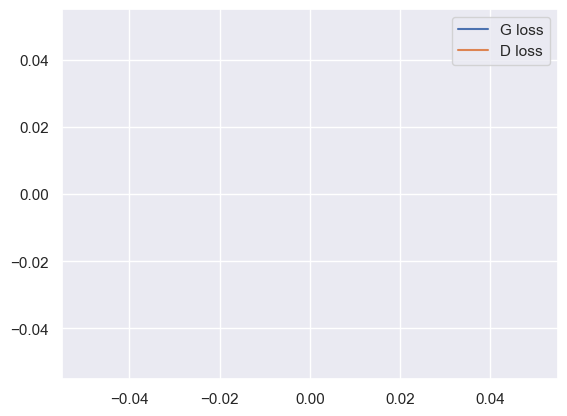

In [11]:
plt.plot(np.log(losses))
# plt.ylim([-3,3])
plt.legend(['G loss','D loss'])

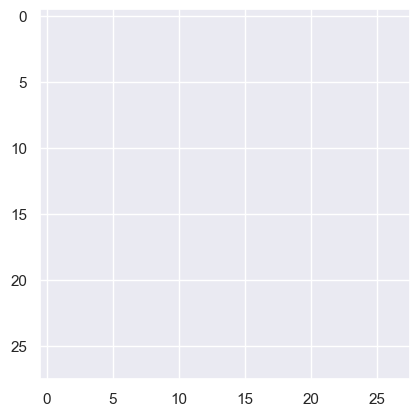

In [12]:
with torch.no_grad():
    z = real_batch.new(3, z_dim).normal_()
    fake_batch = model_G(z).detach()
    
plt.imshow(fake_batch[0].reshape(28,28),'gray')

## 制作动画

In [13]:
# 使用png图片制作动画
from glob import glob
files = glob('.\gan_images\*.png')

import imageio

gif_images = []
for file in files:
    gif_images.append(imageio.imread(file))   # 读取图片
imageio.mimsave("mnist.gif", gif_images, fps=1)   # 转化为gif动画

## 作业 - 结课前交

生成一维混合高斯分布 $p(x)=w_1 N(\mu_1,\sigma_1^2)+w_2 N(\mu_2,\sigma_2^2)$的500个样本，其中$w_1=w_2=0.5,\mu_1=0.3,\sigma_1=0.1,\mu_2=0.5,\sigma_2=0.1$。

1). 使用高斯核的核密度估计$\hat{f}(x ; h)=\frac{1}{n} \sum_{i=1}^{n} K_{h}\left(x-X_{i}\right)$估计分布, 其中$K(u) = \frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2} u^{2}\right)$

2). 使用GAN模型生成服从 $p(x)$的样本

3). 比较核密度估计和GAN模型密度估计的效果。提示：可以用KL距离计算估计分布和真实分布之间的差异





